# 1. Experiments with control for the confounder

𝑦𝑖=𝜏∗𝑇𝑖+𝑒𝑖

## -Simulate a DGP

In [1]:
import pandas as pd
import numpy as np
import graphviz as gr

In [2]:
np.random.seed(24)
n = 100

sex = np.random.binomial(1, 0.5, n)
age = np.random.normal(60, 30, n)

hospital = np.random.binomial(1, 0.5, n)

medication = np.where(hospital.astype(bool),
                     np.random.binomial(1, 0.9, n),
                     np.random.binomial(1, 0.1, n))

severity = np.where(hospital.astype(bool), 
                    np.random.normal(5, 2, n),
                    np.random.normal(3, 2, n))

recovery = np.random.normal (2 + 0.5 * sex +
                0.03 * age + 0.03 * ((age * 0.1) ** 2) +
                severity +
                sex * severity -
                medication) .astype(int)

hospital = pd.DataFrame(dict(hospital=hospital,
                             sex=sex,
                             age=age,
                             medication=medication,
                             severity=severity,
                             recovery=recovery))

hospital.to_csv("Q2b_data.csv", index=False)

## -DAG

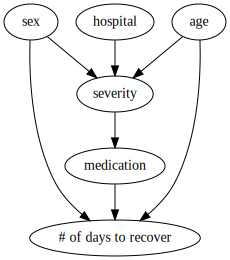

In [3]:
g = gr.Digraph()


g.edge("hospital", "severity")

g.edge("severity", "medication")
g.edge("medication", "# of days to recover")


g.edge("sex", "severity")
g.edge("sex", "# of days to recover")


g.edge("age", "severity")
g.edge("age", "# of days to recover")


g

## -Monte Carlo experiment

In [4]:
data = pd.read_csv("C:/Users/dell/Downloads/Q2b_data.csv")
data.head()

,hospital,sex,age,medication,severity,recovery
0,1,1,55.577194,1,8.454924,20
1,1,1,106.839230,1,3.623485,16
2,0,1,80.541300,1,-0.601679,2
3,1,0,60.883871,1,5.405421,9
4,1,0,34.425752,1,5.860159,8


In [5]:
import statsmodels.formula.api as smf
model = smf.ols('recovery ~ hospital + sex + age + medication + severity', data=data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.8727,0.511,-3.666,0.000,-2.887,-0.859
hospital,-0.8644,0.521,-1.658,0.101,-1.900,0.171
sex,4.2670,0.310,13.766,0.000,3.652,4.882
age,0.0709,0.005,13.378,0.000,0.060,0.081
medication,-0.4123,0.488,-0.845,0.400,-1.382,0.557
severity,1.5946,0.077,20.665,0.000,1.441,1.748


In [6]:
print(data[["medication", "recovery"]].corr())

            medication  recovery
medication    1.000000  0.076535
recovery      0.076535  1.000000


In [7]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [8]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    sex = np.random.binomial(1, 0.5, n)
    age = np.random.normal(60, 30, n)

    hospital = np.random.binomial(1, 0.5, n)

    medication = np.where(hospital.astype(bool),
                         np.random.binomial(1, 0.9, n),
                         np.random.binomial(1, 0.1, n))

    severity = np.where(hospital.astype(bool), 
                        np.random.normal(5, 2, n),
                        np.random.normal(3, 2, n))

    Y = np.random.normal (2 + 0.5 * sex +
                    0.03 * age + 0.03 * ((age * 0.1) ** 2) +
                    severity +
                    sex * severity -
                    medication) .astype(int)

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

In [9]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [10]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    sex = np.random.binomial(1, 0.5, n)
    age = np.random.normal(60, 30, n)

    hospital = np.random.binomial(1, 0.5, n)

    T = np.where(hospital.astype(bool),
                         np.random.binomial(1, 0.9, n),
                         np.random.binomial(1, 0.1, n))

    severity = np.where(hospital.astype(bool), 
                        np.random.normal(5, 2, n),
                        np.random.normal(3, 2, n))

    Yab = np.random.normal (2 + 0.5 * sex +
                    0.03 * age + 0.03 * ((age * 0.1) ** 2) +
                    severity +
                    sex * severity -
                    medication) .astype(int)
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)]
            Yc = Yexp[np.where(T==0)]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

In [11]:
tau = -0.4
corr = 0.08
conf=True
p = 5
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|██████████| 495/495 [00:02<00:00, 237.70it/s]


In [12]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)]
        Yc = Yexp[np.where(T==0)]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:14<00:00, 133.92it/s]


In [13]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')


N=100: bias=2.8230591489094676, RMSE=2.9670407319103944, size=0.8485
N=1000: bias=2.765132403937851, RMSE=2.916702672746742, size=0.852


## -Real-life Example

Higher age increse the possible longer recovery days and also has chance to get serious illness. There may have serious illness differ between gender. Sex and age are the confounder. Both age and sex will cause the illness and recovery days.